In [1]:
# !pip install mdtraj ase nglview

In [2]:
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn import Linear
import sys
import os
import time
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm

import torch.nn.functional as F
from torch_geometric.transforms import pad

In [4]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [5]:
n_frames,n_atoms,n_mols = (0,0,0)
n_neigh = 15

In [6]:
from typing import Optional, Tuple 

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [7]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels,batch_size,n_atoms):
        
        self.embedding_size1 = 15
        self.embedding_size2 = 9
        self.linear_size1 = 100
        self.linear_size2 = 4
        
        self.batch_size = batch_size
        self.n_atoms = n_atoms
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        super().__init__()
        self.conv1 = GATConv(self.in_channels,self.embedding_size1,heads=3)
        self.head_transform1 = Linear(self.embedding_size1*3, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)
        
        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)
        
        self.linear1 = Linear(self.embedding_size2, self.linear_size1)
        self.linear2 = Linear(self.linear_size1,self.linear_size2)
        
        self.transform = Linear(self.linear_size2*self.n_atoms,self.out_channels)
        
        self.mu = Linear(self.out_channels, self.out_channels)
        self.logstd = Linear(self.out_channels, self.out_channels)

    def forward(self, x, edge_index):
        self.batch_size = x.shape[0]//self.n_atoms
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        x = self.bn1(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        
        x = self.linear1(x)
        x = F.leaky_relu(x)

        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = x.reshape(self.batch_size,self.n_atoms,-1)
        x = x.reshape(self.batch_size,-1)
        
        x = self.transform(x)
        x = F.leaky_relu(x)
        
        
        x,y,z = self.mu(x), self.logstd(x), edge_index
        return x,y,z


In [8]:
class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,batch_size,n_atoms):
        self.embedding_size1 = 9
        self.embedding_size2 = 3
        self.embedding_size3 = 3
        self.linear_size1 = 512
        self.linear_size2 = 128
        self.batch_size = batch_size
        self.n_atoms = n_atoms
        self.in_channels = in_channels
        self.out_channels = out_channels

        super().__init__()
        self.inv_transform = Linear(self.in_channels,self.n_atoms) 
        
        self.conv1 = GCNConv(1, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)

        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)

        self.conv3 = GCNConv(self.embedding_size2,self.embedding_size3)

        self.linear1 = Linear(self.embedding_size3, self.linear_size1)
        self.linear2 = Linear(self.linear_size1, self.linear_size2)
        self.linear3 = Linear(self.linear_size2, self.out_channels)

    def forward(self, x, edge_index, sigmoid=True):
        self.batch_size = x.shape[0]//self.n_atoms

        x = self.inv_transform(x)
        x = F.leaky_relu(x)

        x = x.reshape(x.shape[0]*x.shape[1],1)
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)        
        x = self.conv3(x,edge_index)
        
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.linear3(x)
        x = F.leaky_relu(x)

        
        return x, edge_index

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
model_1_name = "model1.pt"
model_stage1 = torch.load("./models/"+model_1_name)
model_stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [10]:
def plotMols(features):
    from mpl_toolkits.mplot3d import Axes3D
    %matplotlib widget
    xyz = features[:,-3:]
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(xyz[:,0],xyz[:,1],xyz[:,2])
    plt.show()

In [11]:
def changeFrame(frame,mol_id):
    L = [0.642130,0.642130,0.642130]    
    features = frame[:,:3]
    xyz = frame[:,3:]
    xyz = xyz - xyz[mol_id]
    xyz = xyz - np.multiply(L,np.round(xyz/L)) 
    frame_recenter = np.concatenate((features,xyz),axis=1)
    return frame_recenter
    

In [12]:

def condenseFrame2(frame):
    mol_pos = []
    edge_list = np.array([[ 0,  1,  0,  2],
                        [ 1,  0,  2,  0]])


    for mol_no,res in enumerate(frame.top.residues):
        pos = []
        for atom in res.atoms:
            pos.append(frame.xyz[0][atom.index])
        pos = np.array(pos)
        avg_pos = np.mean(pos,axis=0)

        pos = pos - pos[0]

        atomic_nums = np.array([[atom.element.atomic_number for atom in res.atoms]]).T
        vdwr = np.array([[atom.element.radius for atom in res.atoms]]).T
        node_features = np.concatenate((pos,vdwr,atomic_nums),axis=1)
        graph = data.Data(x=torch.from_numpy(node_features),edge_index=torch.from_numpy(edge_list)).to("cuda")

        encoded = model_stage1.encode(graph.x,graph.edge_index)

        model_out = np.mean(encoded[0].detach().cpu().numpy(),axis=0)
        feature = np.concatenate((model_out,avg_pos))
            
        mol_pos.append(feature)
        
    mol_pos = np.array(mol_pos)
    
    return mol_pos

def get_graph(frame,mol_id,n_neigh,str_type):
    neigs = getNClosest(frame,mol_id,n_neigh)

    to_list = []
    from_list = []
    for mols_id in range(1,1+len(neigs)):
        to_list.append(mols_id)
        from_list.append(0)
        
        to_list.append(0)
        from_list.append(mols_id)
    
    
    edge_list = np.array([to_list,from_list])
    features = np.concatenate((np.array([frame[mol_id]]),np.array(frame[neigs])),axis=0)
    n_cols = features.shape[1]
    p1 = features[:,n_cols-3:]/10
    p2 = features[:,-3:]*10
    p2 = p2- np.mean(p2,axis=0)
    
    features = np.concatenate((p1,p2),axis=1)
    graph = data.Data(x=torch.from_numpy(features),edge_index=torch.from_numpy(edge_list),y=torch.tensor([0]))
        
    return graph


def get_graphs(frames,str_type):
    graphs = []
    for frame in tqdm(frames):
        for mol_id in range(len(frame)):
#             frame_recon = changeFrame(frame,mol_id)
            graphs.append(get_graph(frame,mol_id,n_neigh,str_type))
    return graphs

def condenseAllFrames(frames):
    """
    Condenses all frames in a trajectory
    """
    condensed_frames = []
    for frame in tqdm(frames):
        condensed_frames.append(condenseFrame2(frame))
    return np.array(condensed_frames)

def getNClosest(frame,mol_id,n):
    """ Returns the n closest molecules to the given molecule. """
    frame = frame[:,-3:]
    coord = frame[mol_id]
    dists = np.linalg.norm(frame-coord,axis=1)
    return np.argsort(dists)[1:n+1]





In [13]:
def pad(graphs):
    max_nodes = 0
    for graph in graphs:
        max_nodes = max(max_nodes,graph.x.shape[0])
    
    padded =[]
    for graph in graphs:
        num_features = graph.num_features
        x = graph.x
        pad = torch.tensor([[0]*num_features] * (max_nodes-x.shape[0]))
        graph.x = torch.concatenate((x,pad))
    
    return graphs


In [14]:
def condenseFrame_same_res_id(f):
    """takes mdtraj frame object as input works even if all molecules have same residue ids
    (divides based on number of atoms in each molecule) """
    n_atoms = 4
    xyz = f.xyz[0]
    r = (np.random.rand(xyz.shape[0],xyz.shape[1]) - 0.5)*0.5
    xyz = xyz + r
    n_parts = xyz.shape[0]//n_atoms
    mols_pos = np.array(np.array_split(xyz,n_parts))

    edge_list = np.array([[ 0,  1,  0,  2],
                        [ 1,  0,  2,  0]])


    atomic_nums =   [[8],[1],[1],[0]]
    vdwr = [[0.152 ],[0.12 ],[0.12 ],[0 ]]
    condensed = []
    for mol_pos in mols_pos:
        avg_pos = np.mean(mol_pos,axis=0)
        recentered = mol_pos - mol_pos[0]
        node_features = np.concatenate((recentered,vdwr,atomic_nums),axis=1)
        graph = data.Data(x=torch.from_numpy(node_features),edge_index=torch.from_numpy(edge_list)).to("cuda")

        encoded = model_stage1.encode(graph.x,graph.edge_index)

        model_out = np.mean(encoded[0].detach().cpu().numpy(),axis=0)
        feature = np.concatenate((model_out,avg_pos))

        condensed.append(feature)
    condensed = np.array(condensed)
    return condensed
def condenseAllFrames_same_res_id(frame,n_frames):
    """
    Condenses all frames in a trajectory
    """
    condensed_frames = []
    for frame_id in tqdm(range(n_frames)):
        cf = condenseFrame_same_res_id(frame)
        
        condensed_frames.append(cf)
        
    return np.array(condensed_frames)


In [15]:
load = True
if load:
    # graphs_cry_cpu = torch.load(f'./graphs/simple/crystal_neigh{n_neigh}.pt')
    graphs_melt_cpu = torch.load(f'./graphs/melt_neigh{n_neigh}.pt')
else:
    # all_frames_cry = md.load_xtc("../simulation/paracetamol/crystal/it3 temp420/md.xtc", top="../simulation/paracetamol/crystal/it3 temp420/md.gro")
    all_frames_melt = md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
    meltframes.xyz=meltframes.xyz*10
    # all_frames_cry.xyz = all_frames_cry.xyz*10
    all_frames_melt.xyz = all_frames_melt.xyz*10
    # all_frames_cry = all_frames_cry[::10]                 # total 167 frames -> taken 167 frames
    all_frames_melt = all_frames_melt[::10]         # total 1667 frames -> taken 167 frames
    global n_frames,n_atoms,n_mols 
    n_frames = all_frames_cry.xyz.shape[0]
    n_atoms = all_frames_cry.topology.residue(0).n_atoms
    n_mols = all_frames_cry.topology.n_residues
    # condensed_crystal = condenseAllFrames(all_frames_cry)
#     condensed_crystal = condenseAllFrames_same_res_id(f,n_frames)
    condensed_melt = condenseAllFrames(all_frames_melt)
    # graphs_cry_cpu = get_graphs(condensed_crystal,"cry")
    graphs_melt_cpu = get_graphs(condensed_melt,"melt")
    # torch.save(graphs_cry_cpu, f'./graphs/simple/crystal_neigh{n_neigh}.pt')
    torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [16]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [17]:
test_frame = md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)
test_frame.xyz = test_frame.xyz*10

In [18]:
cf = condenseFrame2(test_frame)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
def plotGraph(graph):
    plt.figure()
    pos = nx.draw(to_networkx(g), with_labels=True, node_size=50)
    plt.show()

In [ ]:

def plot3D(graph):
    %matplotlib widget

    from mpl_toolkits import mplot3d
    pos = graph.x[:,-3:]

    ax = plt.axes(projection ="3d")
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]

    first = x[0],y[0],z[0]
    ax.scatter3D(x, y, z)
    ax.scatter3D(first[0],first[1],first[2],c="red")
    plt.show()

In [ ]:
def get_graph_2(frame,mol_id,n_neigh,str_type):
    neigs = getNClosest(frame,mol_id,n_neigh)

    to_list = []
    from_list = []
    for mols_id in range(1,1+len(neigs)):
        to_list.append(mols_id)
        from_list.append(0)
        
        to_list.append(0)
        from_list.append(mols_id)
    
    
    edge_list = np.array([to_list,from_list])
    print(np.array(frame[neigs]))
    features = np.concatenate((np.array([frame[mol_id]]),np.array(frame[neigs])),axis=0)
    n_cols = features.shape[1]
    p1 = features[:,n_cols-3:]/10
    p2 = features[:,-3:]*10
    p2 = p2- p2[0]
    
    features = np.concatenate((p1,p2),axis=1)
    if(str_type == "cry"):
        graph = data.Data(x=torch.from_numpy(features),edge_index=torch.from_numpy(edge_list),y=torch.tensor([1]))
    elif (str_type == "melt"):
        graph = data.Data(x=torch.from_numpy(features),edge_index=torch.from_numpy(edge_list),y=torch.tensor([0]))
        
    return graph

[[ 1.83951969  0.14055321  0.49773943 79.52799988 32.41999817 66.35800934]
 [ 1.47329297  1.00798542 -0.76596338 86.66400146 28.92400551 65.61000061]
 [ 1.66382385  0.7657304  -0.43076416 81.19749451 26.01750183 62.65950394]
 [ 2.7621442  -0.38847828  0.56339662 77.23699951 34.34350204 68.33149719]
 [ 3.18735123 -0.35729773  0.41419665 85.20850372 24.70400047 66.27850342]
 [ 5.01363646 -1.9727555   1.62211866 78.54549408 26.20850182 67.64900208]
 [ 0.90417816  0.98236385 -0.10839973 86.52500916 32.93650436 72.30949402]
 [ 2.66510317 -0.29010204  0.65348649 82.99549866 35.98800278 72.62249756]]
tensor([[  8.3242,   3.2119,   6.4490,   0.0000,   0.0000,   0.0000],
        [  7.9528,   3.2420,   6.6358, -37.1400,   3.0100,  18.6801],
        [  8.6664,   2.8924,   6.5610,  34.2200, -31.9499,  11.2000],
        [  8.1197,   2.6018,   6.2660, -20.4451, -61.0150, -18.3049],
        [  7.7237,   3.4344,   6.8331, -60.0500,  22.2450,  38.4150],
        [  8.5209,   2.4704,   6.6279,  19.6650, 

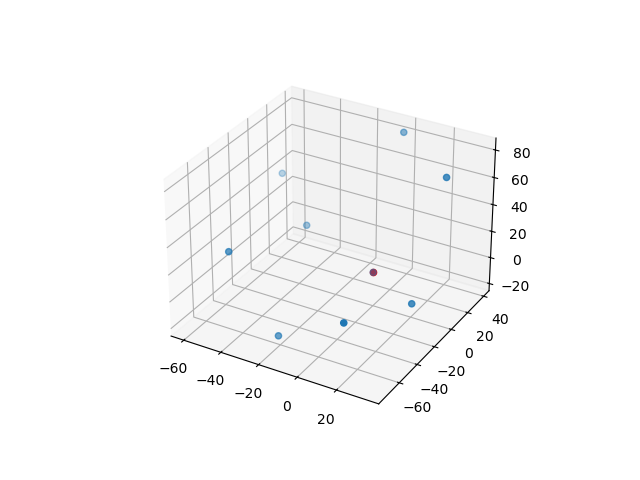

In [ ]:
# %matplotlib widget

g = get_graph_2(cf,60,n_neigh,"cry")
print(g.x)
plot3D(g)

In [ ]:
# graphs_cpu = graphs_cry_cpu + graphs_melt_cpu
# graphs_cpu = graphs_cry_cpu 
graphs_cpu = graphs_melt_cpu


In [ ]:
print(len(graphs_cry_cpu))
print(len(graphs_melt_cpu))

576576
576576


In [ ]:
# shuffle the graphs
np.random.shuffle(graphs_cpu)

## model

In [ ]:
from typing import Optional, Tuple 

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder_S2(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE_S2(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder_S2() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""

        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE_S2(GAE_S2):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    orignal_args = None
    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.orignal_args = args
        self.__mu__, self.__logstd__, self.edge_index,xc = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index,xc

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        if(self.training):
            return self.decoder(*args, **kwargs)
        else:
              
            return self.orignal_args[0] + 0.05*(2*torch.randn_like(self.orignal_args[0]) - 1),self.orignal_args[1]

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [ ]:
class VariationalGCNEncoder_S2(torch.nn.Module):
    def __init__(self, in_channels, out_channels,batch_size,n_mols):
        
        
        self.embedding_size1 = 20
        self.embedding_size2 = 10
        self.linear_size1 = 100
        self.linear_size2 = 4
        self.drop_rate = 0.2
        
        self.batch_size = batch_size
        self.n_mols = n_mols

        self.in_channels = in_channels
        self.out_channels = out_channels
        
        super().__init__()
        self.conv1 = GATConv(self.in_channels,self.embedding_size1,heads=6)
        self.head_transform1 = Linear(self.embedding_size1*6, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)
        
        self.conv2 = GATConv(self.embedding_size1,self.embedding_size2,heads=6)
        self.head_transform2 = Linear(self.embedding_size2*6, self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)
        
        self.linear1 = Linear(self.embedding_size2, self.linear_size1)
        self.drop1 = torch.nn.Dropout(self.drop_rate)
        self.linear2 = Linear(self.linear_size1,self.linear_size2)
        self.drop2 = torch.nn.Dropout(self.drop_rate)

        self.transform = Linear(self.linear_size2*self.n_mols,self.out_channels)
        
        self.classLinear1 = Linear(self.out_channels, self.out_channels)
        self.classdrop1 = torch.nn.Dropout(self.drop_rate)
        self.classLinear2 = Linear(self.out_channels, 2)

        self.mu = Linear(self.out_channels, self.out_channels)
        self.logstd = Linear(self.out_channels, self.out_channels)

    def forward(self, x, edge_index):
        self.batch_size = x.shape[0]//self.n_mols
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        x = self.bn1(x)

        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x = self.bn2(x)
        
        x = self.linear1(x)
        x = self.drop1(x)
        x = F.leaky_relu(x)

        x = self.linear2(x)
        x = self.drop2(x)
        x = F.leaky_relu(x)
        
        x = x.reshape(self.batch_size,self.n_mols,-1)
        x = x.reshape(self.batch_size,-1)
        
        x = self.transform(x)
        x = F.leaky_relu(x)
        
        
        # class prediction network
        xc = self.classLinear1(x)
        xc = self.classdrop1(xc)
        xc = F.leaky_relu(xc)
        xc = self.classLinear2(xc)
        # xc = torch.sigmoid(xc)          # FIXME: Add softmax
        xc = F.softmax(xc,dim=1)
        x,y,z = self.mu(x), self.logstd(x), edge_index
        return x,y,z,xc


In [ ]:
class VariationalGCNDecoder_S2(torch.nn.Module):
    def __init__(self,in_channels,out_channels,batch_size,n_mols):
        self.embedding_size1 = 3
        self.embedding_size2 = 10
        self.embedding_size3 = 30
        self.linear_size1 = 128
        self.linear_size2 = 64
        self.batch_size = batch_size
        self.n_mols = n_mols
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.drop_rate = 0.2
        super().__init__()
        self.inv_transform = Linear(self.in_channels,self.in_channels * self.n_mols) 
        
        self.conv1 = GCNConv(self.in_channels, self.embedding_size1)
        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.conv3 = GCNConv(self.embedding_size2,self.embedding_size3)

        self.bn = BatchNorm(self.embedding_size3)

        
        self.linear1 = Linear(self.embedding_size3, self.linear_size1)
        self.drop1 = torch.nn.Dropout(self.drop_rate)
        self.linear2 = Linear(self.linear_size1, self.linear_size2)
        self.drop2 = torch.nn.Dropout(self.drop_rate)
        self.linear3 = Linear(self.linear_size2, self.out_channels)

    def forward(self, x, edge_index, sigmoid=True):
        self.batch_size = x.shape[0]
        # print("in:",x.shape)
        x = self.inv_transform(x)
        x = F.leaky_relu(x)
        # print("inv trans:",x.shape)

        x = x.reshape(self.batch_size*self.n_mols,self.in_channels)
        # print("reshape:",x.shape)
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)        
        x = self.conv3(x,edge_index)
        x = self.bn(x)
        # print("conv:",x.shape)

        x = self.linear1(x)
        x = self.drop1(x)
        x = torch.tanh(x)

        x = self.linear2(x)
        
        x = torch.tanh(x)
        x = self.linear3(x)
        x = F.leaky_relu(x)
        # print("out:",x.shape)
        
        return x, edge_index

In [ ]:
import os
from torch.utils.tensorboard import SummaryWriter

in_channels = graphs_cpu[0].num_features
out_channels = 3
lr = 0.001
n_epochs = 1000
batch_size=512

train_split = 0.8
test_split = 0.1
val_split = 0.1

model_name = f"VGAE_S2_{n_neigh}_neigh_{batch_size}_batch_{lr}_lr_{out_channels}_out_channels_class_loss_chamfer_both"
# model_name = "VGAE_S2_15_neigh_512_batch_0.01_lr_only_chamfer_loss.pt"
model_loaded = False
force_train = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./models/"+model_name+".pt") and not force_train:
    model = torch.load("./models/"+model_name+'.pt')
    model_loaded = True
else:
    global n_mols
    n_mols = n_neigh+1
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_mols),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_mols))

model = model.to(device)
model = model.double()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)


In [ ]:
if model_loaded:
    print("Model Loaded")
else:
    print("Model not loaded, will start training")

Model Loaded


In [ ]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

  0%|          | 0/1153152 [00:00<?, ?it/s]

100%|██████████| 1153152/1153152 [01:33<00:00, 12309.39it/s]


In [ ]:
graphs = graphs_device
total_graphs = len(graphs)

In [ ]:
train_graphs = graphs[:int(train_split*total_graphs)]
test_graphs = graphs[int(train_split*total_graphs):int((train_split+test_split)*total_graphs)]
val_graphs = graphs[int((train_split+test_split)*total_graphs):]

train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=True)

In [ ]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("\ttrain_graphs:", len(train_graphs))
print("\ttest_graphs:", len(test_graphs))
print("\tval_graphs:", len(val_graphs))
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 1153152
	train_graphs: 922521
	test_graphs: 115315
	val_graphs: 115316
batch Size: 512
number of batches: 2252
Neighbours: 8
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 20, heads=6)
    (head_transform1): Linear(in_features=120, out_features=20, bias=True)
    (bn1): BatchNorm(20)
    (conv2): GATConv(20, 10, heads=6)
    (head_transform2): Linear(in_features=60, out_features=10, bias=True)
    (bn2): BatchNorm(10)
    (linear1): Linear(in_features=10, out_features=100, bias=True)
    (drop1): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=100, out_features=4, bias=True)
    (drop2): Dropout(p=0.2, inplace=False)
    (transform): Linear(in_features=36, out_features=3, bias=True)
    (classLinear1): Linear(in_features=3, out_features=3, bias=True)
    (classdrop1): Dropout(p=0.2, inplace=False)
    (classLinear2): Linear(in_features=3, out_features=2, bias=True)
    (mu): Linear(in_features=3, out_features=3, 

In [ ]:
# import chamfer loss from pytorch3d
from pytorch3d.loss import chamfer_distance


In [ ]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()


def train():
    model.train()
    model.zero_grad()
    all_loss_feature = 0
    all_loss_chamfer = 0
    all_loss_class = 0
    total_loss = 0
    global n_mols
    for data in train_loader:
        batch_size = data.x.shape[0]//n_mols

        optimizer.zero_grad()
        z,encoded_edge_index,xc = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        
        labels = F.one_hot(data.y,num_classes = 2).double().to(device)
        
        pos = data.x[:,-3:]
        pos_pred = decoded_x[:,-3:]
        
        features = data.x[:,:-3]
        features_pred = decoded_x[:,:-3]

        
        pos_pred = pos_pred.reshape(batch_size,n_mols,-1)
        pos = pos.reshape(batch_size,n_mols,-1)
        
        ch_loss,_ = chamfer_distance(pos, pos_pred)
        features_loss = MSE_loss(features,features_pred)
        class_loss = MSE_loss(xc,labels)


        loss = ch_loss + features_loss + 100*class_loss

        loss.backward()
        
        all_loss_feature += float(features_loss)
        all_loss_chamfer += float(ch_loss)
        all_loss_class += float(class_loss)
        total_loss += float(loss)

        optimizer.step()


    return features_loss/len(train_loader), all_loss_chamfer/len(train_loader), total_loss/len(train_loader), all_loss_class/len(train_loader)

In [ ]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_feature = 0
    all_loss_chamfer = 0
    all_loss_class = 0
    total_loss = 0
    global n_mols
    for data in test_loader:
        batch_size = data.x.shape[0]//n_mols
        optimizer.zero_grad()
        z,encoded_edge_index,xc = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        labels = F.one_hot(data.y,num_classes = 2).double().to(device)

        pos = data.x[:,-3:]
        pos_pred = decoded_x[:,-3:]
        
        features = data.x[:,:-3]
        features_pred = decoded_x[:,:-3]

        
        pos_pred = pos_pred.reshape(batch_size,n_mols,-1)
        pos = pos.reshape(batch_size,n_mols,-1)
        ch_loss,_ = chamfer_distance(pos, pos_pred)

        features_loss = MSE_loss(features,features_pred)
        class_loss = MSE_loss(xc,labels)

        loss =   ch_loss + features_loss + 100*class_loss



        all_loss_feature += float(features_loss)
        all_loss_chamfer += float(ch_loss)
        all_loss_class += float(class_loss)
        total_loss += float(loss)


    return all_loss_feature/len(test_loader), all_loss_chamfer/len(test_loader), total_loss/len(test_loader), all_loss_class/len(test_loader)

In [ ]:
train_losses = []
test_losses = []
best_loss = 999999

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    writer = SummaryWriter(comment=model_name)

    for epoch in range(1, n_epochs + 1):

        # every 50 epoch load the best model and reset the learning rate
        # if(epoch%50 == 0):
        #     print("Loading best model, Loss:",best_loss)
        #     model = torch.load("./models/"+model_name+"_best.pt")


        train_loss_feature,train_loss_chamfer,train_total_loss,train_class_loss = train()
        test_loss_feature,test_loss_chamfer,test_total_loss,test_class_loss = test()
            
        print(f"Epoch: {epoch:03d}, LR: {scheduler.get_last_lr()}")
        print(f'\tTrain:\tChamfer Loss: {train_loss_chamfer:.4f}\tFeature Loss: {train_loss_feature:.4f}\ttotal loss: {train_total_loss:.4f},\tclass loss: {train_class_loss:.4f}' )
        print(f'\tTest: \tChamfer Loss: {test_loss_chamfer:.4f}\tFeature loss: {test_loss_feature:.4f}\ttotal loss: {test_total_loss:.4f},\tclass loss: {test_class_loss:.4f}' )

        writer.add_scalar("Train/Feature", train_loss_feature, epoch)
        writer.add_scalar("Test/Feature", test_loss_feature, epoch)

        writer.add_scalar("Train/Chamfer", train_loss_chamfer, epoch)
        writer.add_scalar("Test/Chamfer", test_loss_chamfer, epoch)

        writer.add_scalar("Train/Total", train_total_loss, epoch)
        writer.add_scalar("Test/Total", test_total_loss, epoch)

        writer.add_scalar("Train/Class", train_class_loss, epoch)
        writer.add_scalar("Test/Class", test_class_loss, epoch)

        if(epoch > 15 and best_loss > test_loss_chamfer):
            best_loss = test_loss_chamfer
            torch.save(model,"./models/"+model_name+"_best.pt")
            print("best model saved, Loss:",best_loss)
        

        if(epoch%100 == 0):
            torch.save(model,"./models/"+model_name+".pt")

        scheduler.step()
        writer.flush()
    writer.close()
    torch.save(model,"./models"+model_name+"_complete.pt")

Pretrained Model Loaded, no training required


In [ ]:
val_loader = DataLoader(val_graphs, batch_size=1, shuffle=True)
orignal = []
recon_list = []
latent = []
predicted_label = []
orignal_label = []
raw_pred = []
for i,data in enumerate(tqdm(val_loader)):
    model.eval()
    data = data.to(device)
    
    z,edge_index,xc = model.encode(data.x,data.edge_index)
    recon,edge_index = model.decode(z,edge_index)
    
    if(i>1000):
        break
    orignal.append(data.x.cpu().detach())
    recon_list.append(recon.cpu().detach())
    latent.append(z.cpu().detach()) 
    orignal_label.append(data.y.cpu().detach()[0])
    predicted_label.append(np.argmax(xc.cpu().detach()))
    raw_pred.append(xc.cpu().detach())

recon_list = np.array(recon_list)
latent = np.array(latent)
predicted_label = np.array(predicted_label)
orignal_label = np.array(orignal_label)
raw_pred = np.array(raw_pred)

  1%|          | 1001/115316 [00:04<08:18, 229.12it/s]


In [ ]:
def plotCompare(features1,features2):
    %matplotlib widget
    xyz1 = features1[:,-3:]
    xyz2 = features2[:,-3:]
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(xyz1[:,0],xyz1[:,1],xyz1[:,2],label="recon")
    ax1.scatter(xyz2[:,0],xyz2[:,1],xyz2[:,2],label="orignal")
    plt.legend()
    plt.show()

0 0


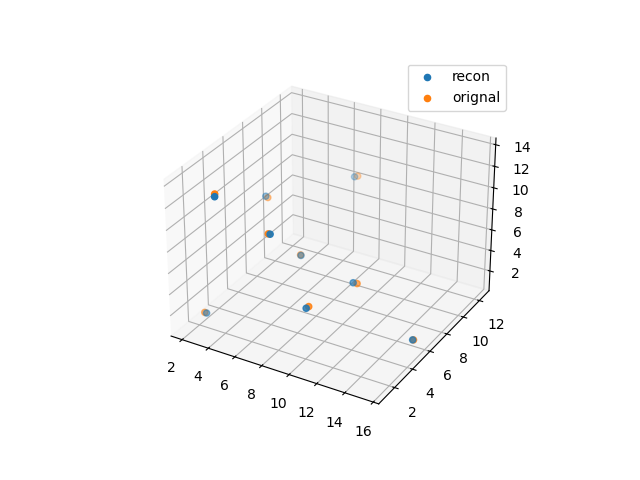

In [ ]:
index = 4
print(orignal_label[index],predicted_label[index])
plotCompare(recon_list[index],orignal[index])

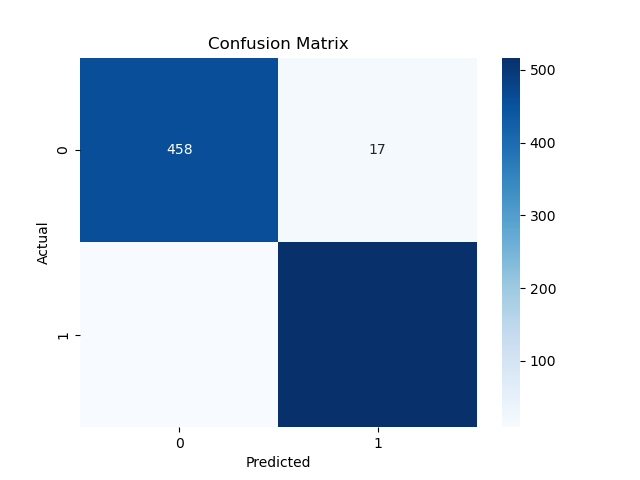

[[458  17]
 [  9 517]]


In [ ]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(orignal_label,predicted_label)

plt.figure()
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(cm)


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy: ",accuracy_score(orignal_label,predicted_label)*100, "%")


Accuracy:  97.40259740259741 %


In [ ]:
# plot the latent space in 3d

crystal,melt = [],[]

for i in range(len(latent)):
    cur_latent = latent[i].reshape(-1)
    cur_latent = np.concatenate((cur_latent,[raw_pred[i][0][0]]))
    if(orignal_label[i] == 1):
        crystal.append(cur_latent)
    else:
        melt.append(cur_latent)

crystal = np.array(crystal)
melt = np.array(melt)



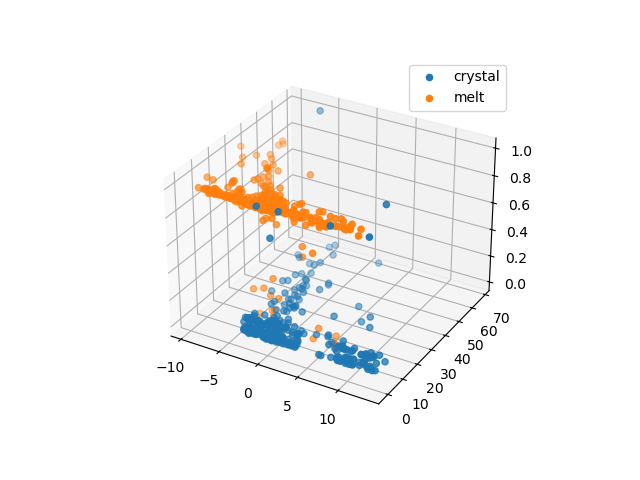

In [ ]:
crystal = crystal.reshape(crystal.shape[0],-1)
melt = melt.reshape(melt.shape[0],-1)

%matplotlib widget
xyz1 = crystal[:,-3:]
xyz2 = melt[:,-3:]
fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter(xyz1[:,0],xyz1[:,1],xyz1[:,2],label="crystal")
ax1.scatter(xyz2[:,0],xyz2[:,1],xyz2[:,2],label="melt")
plt.legend()
plt.show()